# 01 Importing Libraries

In [3]:
import sys  
!{sys.executable} -m pip install --user quandl

  Using cached Quandl-3.7.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached Quandl-3.7.0-py2.py3-none-any.whl (26 kB)


In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'DMECrssf81Nez_KY8UYJ'

# 02 Import Data

In [3]:
path = r'C:\Users\isava\OneDrive\Documents\CareerFoundry\Data Immersion\AdvancedAnalytics\WorldRiskIndex'

In [146]:
df = pd.read_csv(os.path.join(path,'02 Data','CleanedData', 'world_risk_index_cleaned.csv'))

In [35]:
df.head()

,Region,WRI,Exposure,Vulnerability,Susceptibility,Lack of Coping Capabilities,Lack of Adaptive Capacities,Year,Exposure Category,WRI Category,Vulnerability Category,Susceptibility Category
0,Vanuatu,32.00,56.33,56.81,37.14,79.34,53.96,2011,Very High,Very High,High,High
1,Tonga,29.08,56.04,51.90,28.94,81.80,44.97,2011,Very High,Very High,Medium,Medium
2,Philippines,24.32,45.09,53.93,34.99,82.78,44.01,2011,Very High,Very High,High,High
3,Solomon Islands,23.51,36.40,64.60,44.11,85.95,63.74,2011,Very High,Very High,Very High,High
4,Guatemala,20.88,38.42,54.35,35.36,77.83,49.87,2011,Very High,Very High,High,High


In [4]:
temp = pd.read_csv(os.path.join(path,'02 Data','OriginalData', 'Monthly_LandOcean_TempAnomaly_2000_2022.csv')) #To get this to work I had to remove some extra header rows manually from the csv in excel.
temp.head()

,Date,Anomaly
0,200001,0.31
1,200002,0.54
2,200003,0.53
3,200004,0.59
4,200005,0.37


The nasdaq site did not have any data that was related to my dataset. 

I will be conducting a time series analysis on both my own data and the global tempearture anomalies found here: https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series (Click Download CSV below the bar chart)

- I am interested to see how these risk index indicators change over time. I may be able to compare them to some outward factors later on such as natural disaster rate, climate change indicators, GDP, GNI Index, etc. Although, I would like to note that my data is only based on a yearly average.
- The global time series anomalies are based on the global avereage from 1901-2000. They are collected from NOAA.
- The temperature data is for land and sea. I did not want to leave out any factors that could effect natural disasters such as hurricane which can be largely affected by water tempeatures.
- Temperature anomalies are in celsius.
- Datasets missing values are indicated as -999.

# 03 Data Prep for Analysis

#### WRI

I need to prep my data to have one measure per year. 

In [68]:
# Create a subset with the desired columns
df_sub = df[['Year', 'WRI']]
df_sub.head()

,Year,WRI
0,2011,32.00
1,2011,29.08
2,2011,24.32
3,2011,23.51
4,2011,20.88


(array([783., 829., 206.,  53.,  20.,  14.,   6.,   0.,   3.,   1.]),
 array([2.0000e-02, 5.6890e+00, 1.1358e+01, 1.7027e+01, 2.2696e+01,
        2.8365e+01, 3.4034e+01, 3.9703e+01, 4.5372e+01, 5.1041e+01,
        5.6710e+01]),
 <BarContainer object of 10 artists>)

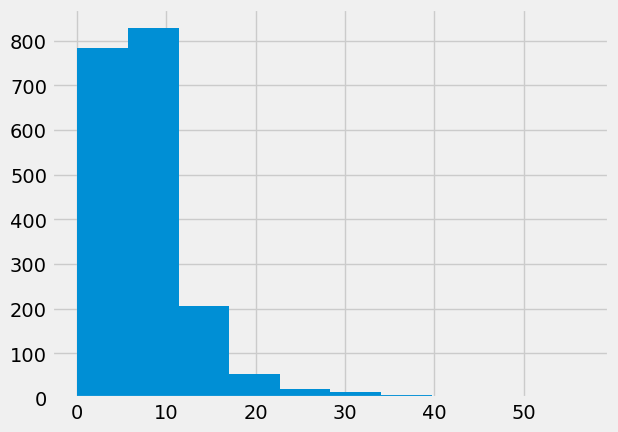

In [44]:
plt.hist(df_sub['WRI'])

WRI is right-skewed so the median would be a better central measure.

In [70]:
# Group by date with the median of the avg delay
df_sub = df_sub.groupby('Year')['WRI'].median()

In [120]:
df_sub

Year
2011    6.830
2012    6.630
2013    6.570
2014    6.630
2015    6.550
2016    6.390
2017    6.570
2018    6.165
2019    6.485
2020    6.420
2021    6.600
Name: WRI, dtype: float64

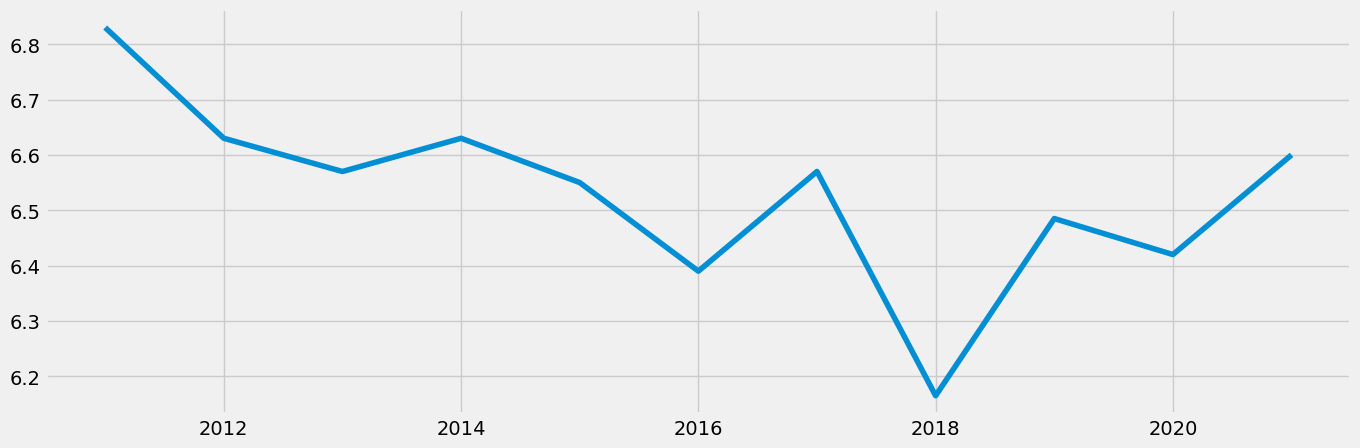

In [74]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_sub)

I see an overall decrease with the minimum in 2018. Since then there has been a general WRI increase but it is sitll lower than 2011.

Below I am resetting my index to use the year. This is needed for datetime functions later on in the analysis.

In [192]:
df_ts = df_sub.reset_index()
df_ts.head() #Resetting to set the year as the index.

,Year,WRI
0,2011,6.83
1,2012,6.63
2,2013,6.57
3,2014,6.63
4,2015,6.55


In [194]:
from datetime import datetime

df_ts['datetime'] = pd.to_datetime(df_ts['Year'], format = '%Y') # Create a datetime column from Year
df_ts.head()

,Year,WRI,datetime
0,2011,6.83,2011-01-01
1,2012,6.63,2012-01-01
2,2013,6.57,2013-01-01
3,2014,6.63,2014-01-01
4,2015,6.55,2015-01-01


In [196]:
df_ts = df_ts.set_index('datetime') # Set the datetime as the index of the dataframe.
df_ts.drop(['Year'], axis=1, inplace=True) # Drop the "Date" column.
df_ts.head()

,WRI
datetime,
2011-01-01,6.83
2012-01-01,6.63
2013-01-01,6.57
2014-01-01,6.63
2015-01-01,6.55


#### Temp Anomalies

This data needs to be cleaned and prepared for time series analysis.

In [253]:
temp.describe()

,Date,Anomaly
count,276.000000,276.000000
mean,201106.500000,0.735797
std,664.538908,0.192039
min,200001.000000,0.280000
25%,200509.750000,0.600000
50%,201106.500000,0.700000
75%,201703.250000,0.880000
max,202212.000000,1.340000


There are no values of -999 which indicates no missing values according to NOAAs documentation.

In [189]:
sum(temp.duplicated())

0

No duplicates

In [9]:
temp['datetime'] = pd.to_datetime(temp['Date'], format = '%Y%m') # Create a datetime column from YearMonth format
temp

,Date,Anomaly,datetime
0,200001,0.31,2000-01-01
1,200002,0.54,2000-02-01
2,200003,0.53,2000-03-01
3,200004,0.59,2000-04-01
4,200005,0.37,2000-05-01
...,...,...,...
271,202208,0.93,2022-08-01
272,202209,0.88,2022-09-01
273,202210,0.96,2022-10-01
274,202211,0.75,2022-11-01


In [11]:
temp_clean = temp.set_index('datetime') # Set the datetime as the index of the dataframe.
temp_clean.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
temp_clean.head()

,Anomaly
datetime,
2000-01-01,0.31
2000-02-01,0.54
2000-03-01,0.53
2000-04-01,0.59
2000-05-01,0.37


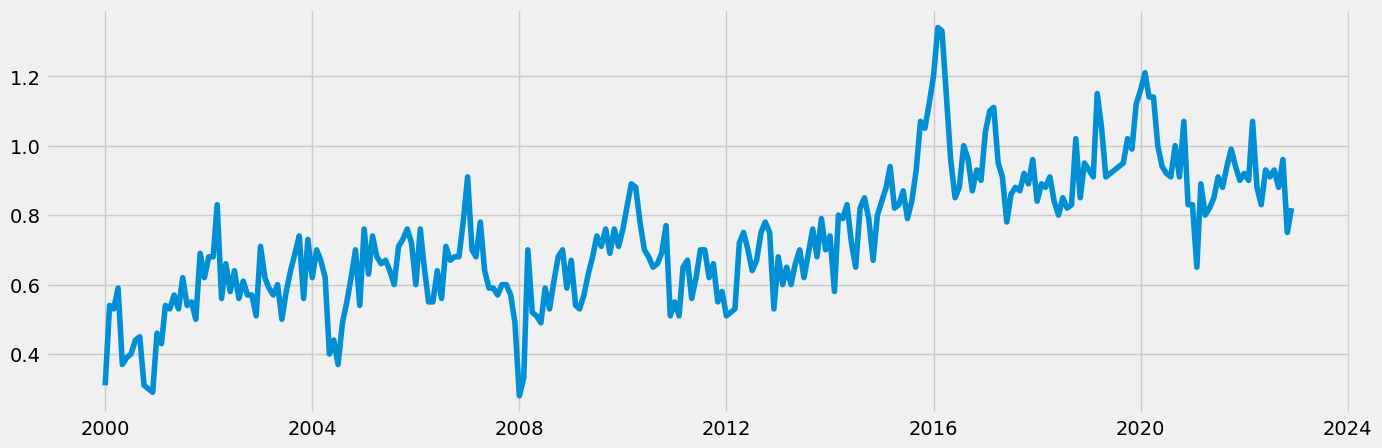

In [13]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(temp_clean)

temp

In [19]:
temp_clean.head()

,Anomaly
datetime,
2000-01-01,0.31
2000-02-01,0.54
2000-03-01,0.53
2000-04-01,0.59
2000-05-01,0.37


# 04 Time Series Analysis

## Decomposition

#### WRI

In [112]:
decomposition = sm.tsa.seasonal_decompose(df_ts, model='multiplicative') #data appears to be non linear

In [114]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

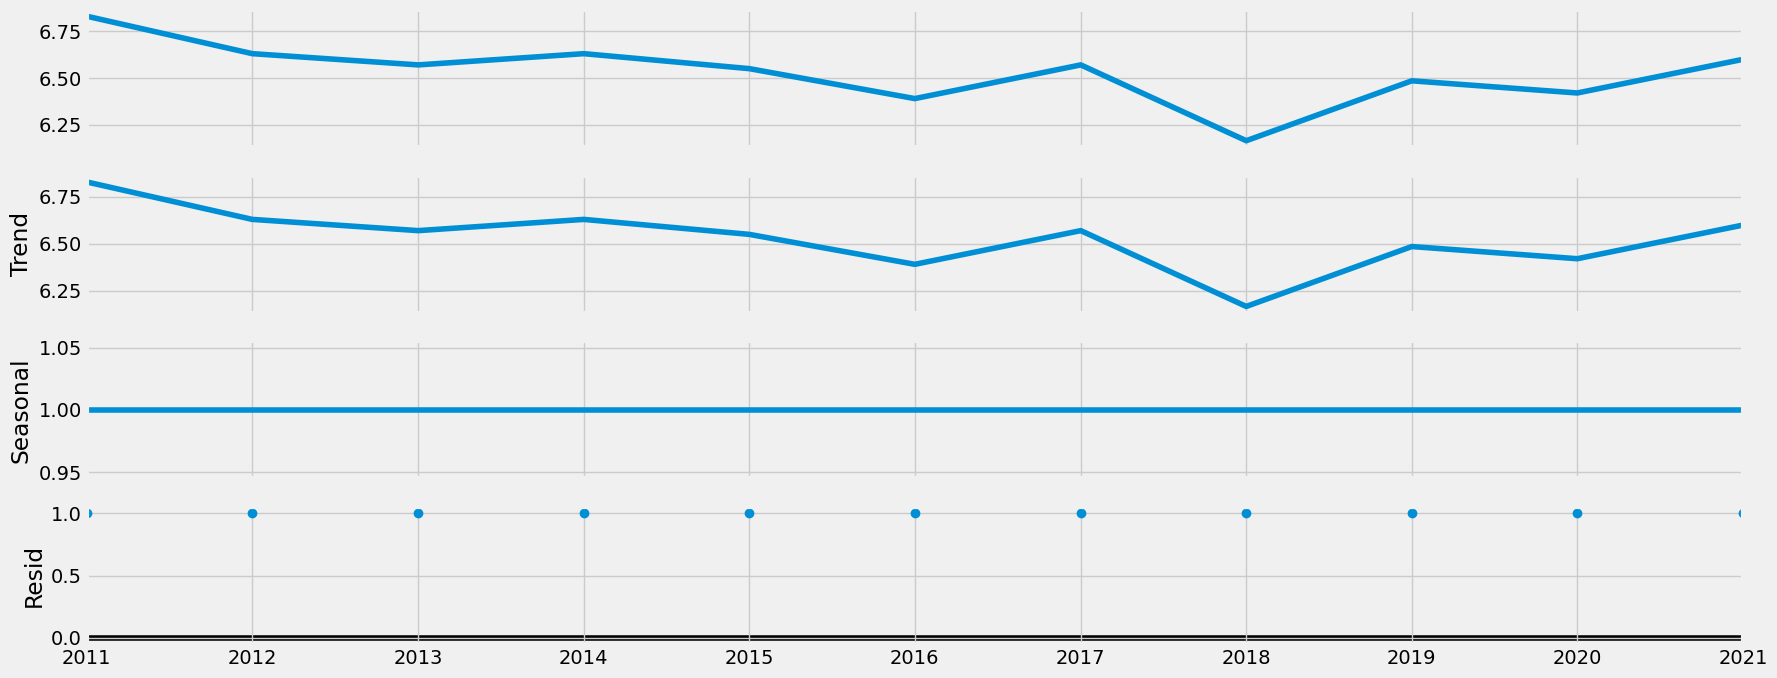

In [116]:
# Plot the separate components

decomposition.plot()
plt.show()

The annual data affects the result here. The **trend** reveals a downward pattern with a small upturn in 2018. Since the data is yearly there is no seasonal trend noticed. There is also no residual data to either. Overall, it appears that this is stationary but that will be statisticaly tested.

### Temp Anomalies

In [208]:
decomposition = sm.tsa.seasonal_decompose(temp_clean, model='multiplicative') #data appears to be non linear

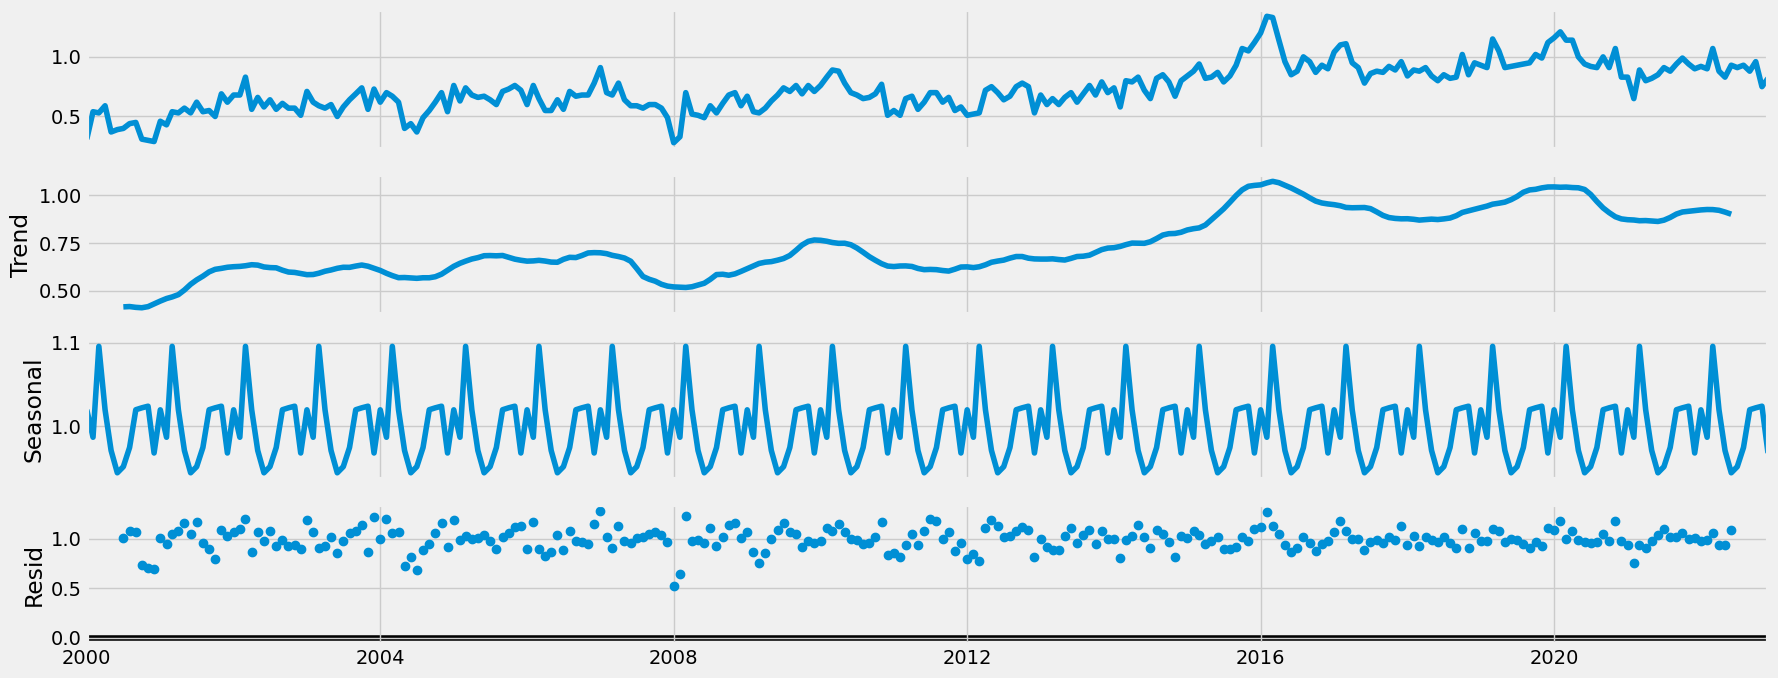

In [210]:
# Plot the separate components

decomposition.plot()
plt.show()

- Trend reveals that there are many minor fluctuations in the data so this trend line appears more smooth than the line plot. There is an overall increase with some notable rises and falls througnout the years such as a jump in 2016.
- There is clear seasonality in the anomaly data. This makes sense since seasons do affect temperatures.
- Finally the data does appear to be relatively consistent over time as seen in the  Resid plot. There are some outliers in 2008. Overall, there is not too much unexplained noise.

- My guess is that this data is not stationary due to the consistent increase in the data. Again this will be tested via the Dickey-Fuller statistical test. 

## Stationarity

Refers to a time series whose statistical measures remain constant. When it comes to forecasting we need data with properties that do not change. This will be checked with a Dickey-Fuller test which checks for the presence of a unit root. A unit root is a jump that cannot be explained by the variation of the data, hence making the time-series non-stationary.

Null hypothesis is the existence of a unit root. This is equivalent to the time series being non-stationary.

#### WRI

In [231]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_ts['WRI'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.129416
p-value                         0.024452
Number of Lags Used             0.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


P-value < 0.05 therefore we can reject the null hypothesis and determine that there is no unit root in the WRI data set. This equates to a stationary dataset.

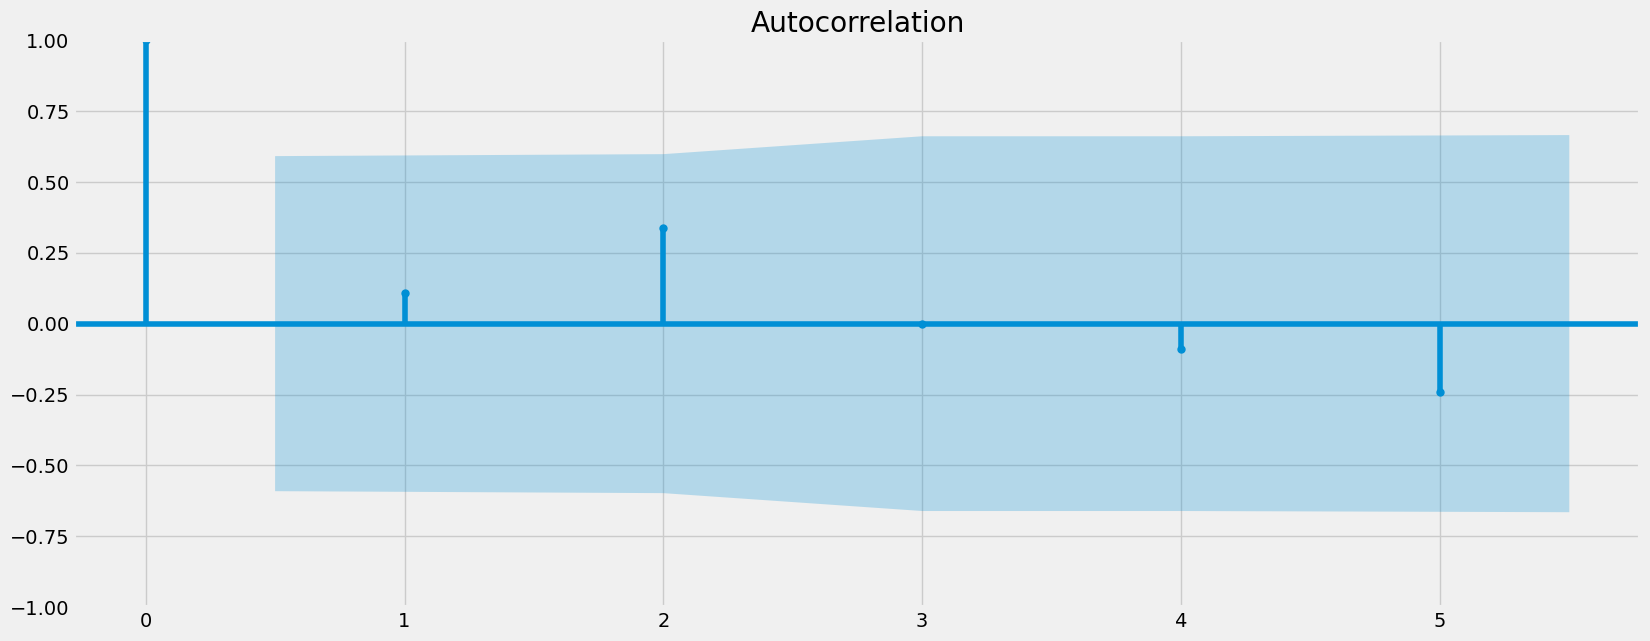

In [235]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_ts)
plt.show()

Seemingly random lags (vertical bars) mostly within the confidence intervals (blue), again supporting the stationary dataset claim.

#### Temp Anomalies

In [240]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(temp_clean['Anomaly'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.583806
p-value                          0.096391
Number of Lags Used              3.000000
Number of Observations Used    272.000000
Critical Value (1%)             -3.454622
Critical Value (5%)             -2.872225
Critical Value (10%)            -2.572464
dtype: float64


The p value is above 0.05 so we are unable to reject the null hypothesis. This indicates that the time-series is non-stationary and does contain  a unit root.

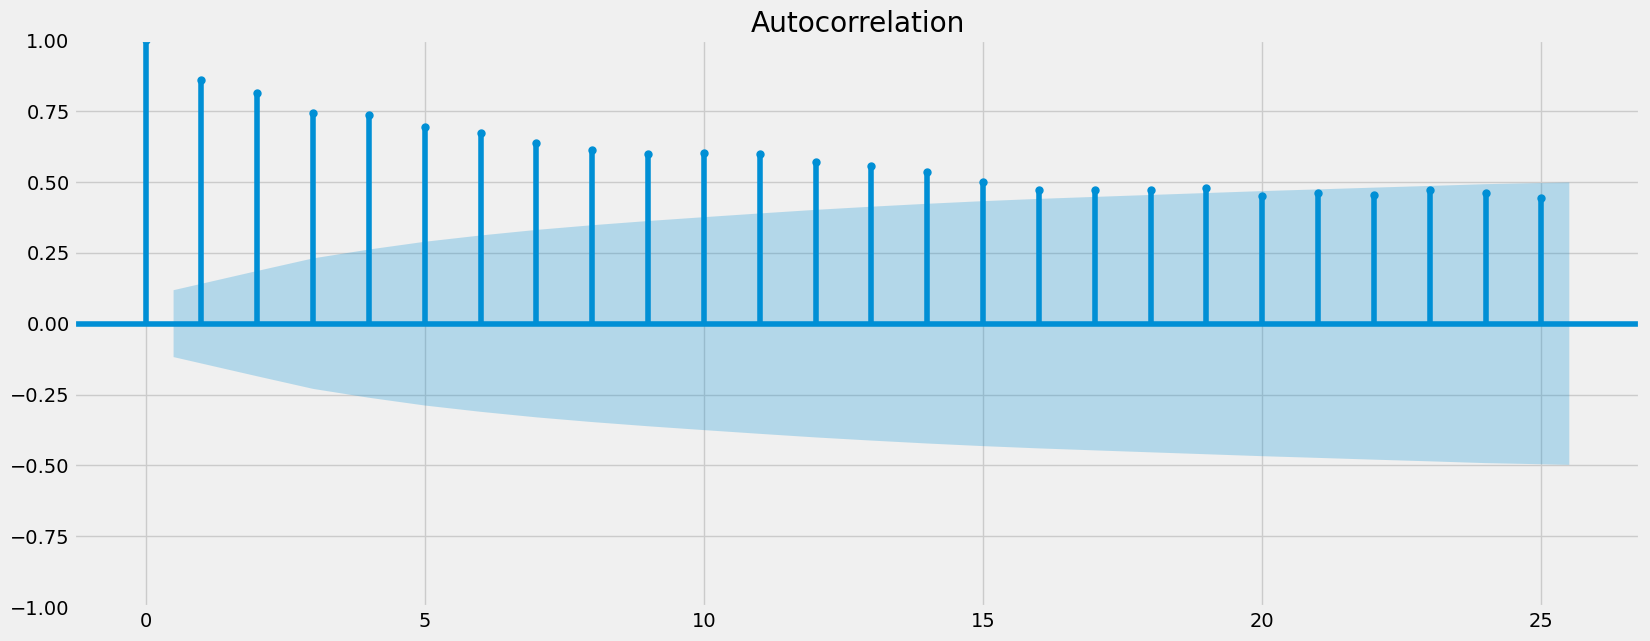

In [243]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(temp_clean)
plt.show()

Many lags are outside the confidence intervals indicating a presence of auotcorrelation and supporting the non-stationary claim. Lets try to force stationarity.

##### Differencing

In [259]:
temp_clean_diff = temp_clean - temp_clean.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [261]:
temp_clean_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [263]:
temp_clean_diff.head()

,Anomaly
datetime,
2000-02-01,0.23
2000-03-01,-0.01
2000-04-01,0.06
2000-05-01,-0.22
2000-06-01,0.02


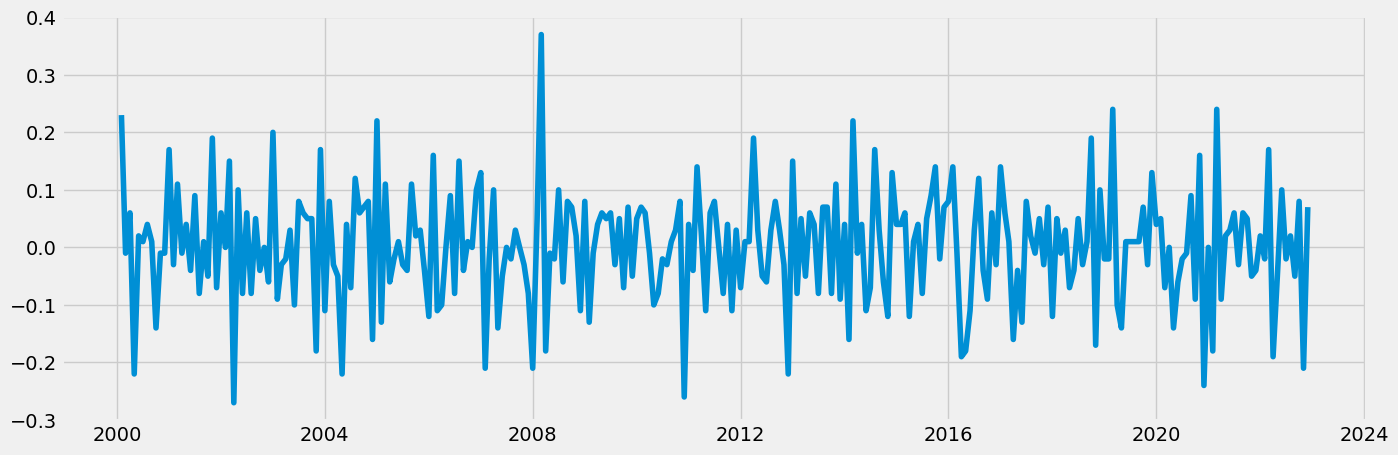

In [267]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(temp_clean_diff)

This appears much more stationary, the mean of the data appears to be around 0. We will check again with the Dickey-Fuller test.

In [269]:
dickey_fuller(temp_clean_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.340724e+01
p-value                        4.445547e-25
Number of Lags Used            2.000000e+00
Number of Observations Used    2.720000e+02
Critical Value (1%)           -3.454622e+00
Critical Value (5%)           -2.872225e+00
Critical Value (10%)          -2.572464e+00
dtype: float64


The p-value is less than 0.05 so we can reject the null hypothesis of non-stationary data and considere this as stationary.

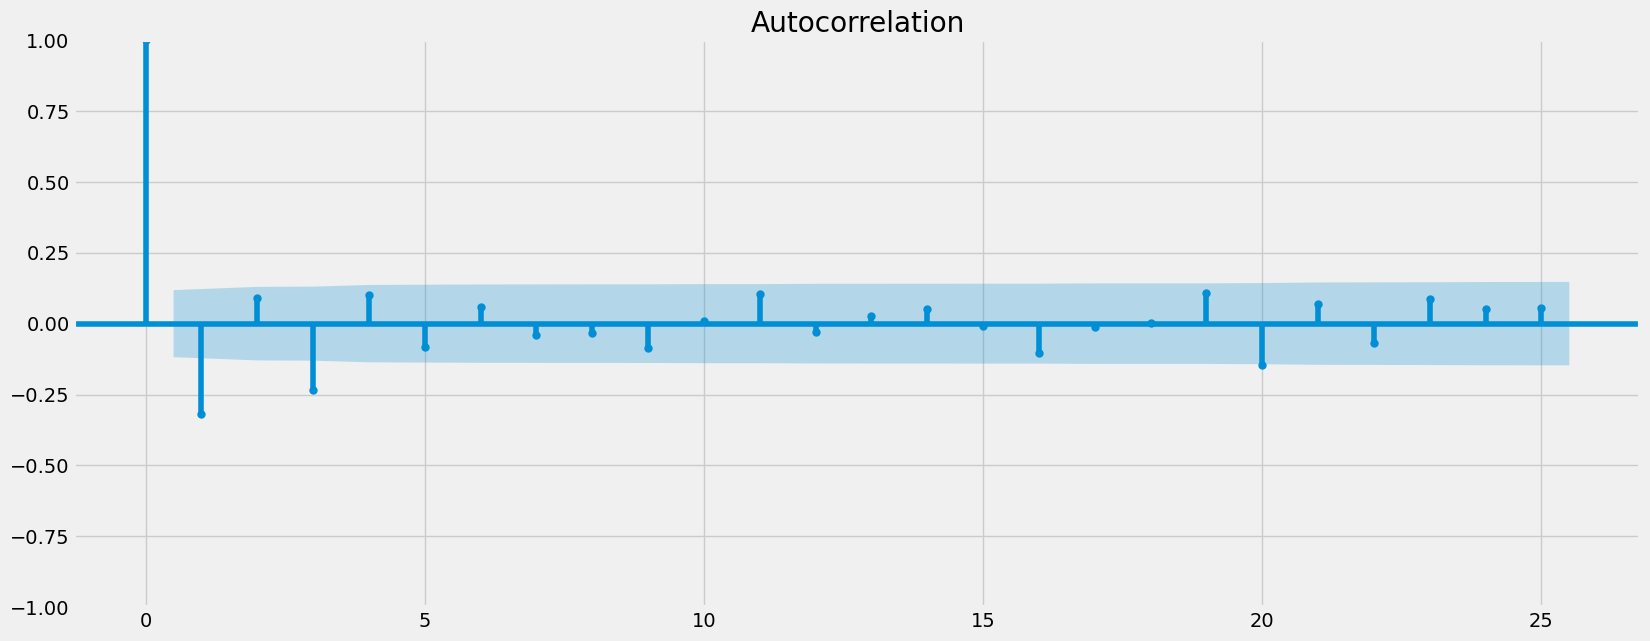

In [271]:
plot_acf(temp_clean_diff)
plt.show()

There is not too much autocorrelation outside the confidence intervals. I would still consider this stationary.

# 05 Write Data

In [23]:
#df.to_csv(os.path.join(path,'02 Data','CleanedData', 'temp_anomaly_stationary.csv'), index = False)
temp_clean.to_csv(os.path.join(path,'02 Data','CleanedData', 'temp_anomaly.csv'), index = True)

# 06 Citations

NOAA National Centers for Environmental information, Climate at a Glance: Global Time Series, published March 2025, retrieved on March 15, 2025 from https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series